In [1]:
import gradio as gr
import torch
from transformers import AutoConfig, AutoModelForCausalLM
from janus.models import MultiModalityCausalLM, VLChatProcessor
from janus.utils.io import load_pil_images
from demo.cam import generate_gradcam, AttentionGuidedCAM
from captum.attr import LayerGradCam
from PIL import Image
from einops import rearrange

import numpy as np
import matplotlib.pyplot as plt
import os
import time

import torch.nn.functional as F
from scipy.ndimage import filters
from torch import nn

c:\Users\Austi\anaconda3\envs\janus_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Python version is above 3.10, patching the collections module.


c:\Users\Austi\anaconda3\envs\janus_env\lib\site-packages\transformers\models\auto\image_processing_auto.py:590: FutureWarning: The image_processor_class argument is deprecated and will be removed in v4.42. Please use `slow_image_processor_class`, or `fast_image_processor_class` instead
  warnings.warn(


In [2]:

model_path = "deepseek-ai/Janus-Pro-7B"
config = AutoConfig.from_pretrained(model_path)
language_config = config.language_config
language_config._attn_implementation = 'eager'
vl_gpt = AutoModelForCausalLM.from_pretrained(model_path,
                                             language_config=language_config,
                                             trust_remote_code=True,
                                             ignore_mismatched_sizes=True # Adding CLS token, will be handled manually
                                             )

dtype = torch.bfloat16 if torch.cuda.is_available() else torch.float16
# dtype = torch.bfloat32 if torch.cuda.is_available() else torch.float32

if torch.cuda.is_available():
    vl_gpt = vl_gpt.to(dtype).cuda()
else:
    # vl_gpt = vl_gpt.to(torch.float16)
    torch.set_default_device("mps")
    vl_gpt = vl_gpt.to(dtype)

vl_chat_processor = VLChatProcessor.from_pretrained(model_path)
tokenizer = vl_chat_processor.tokenizer
cuda_device = 'cuda' if torch.cuda.is_available() else 'mps'

Usage Class Token:  True


Loading checkpoint shards: 100%|██████████| 2/2 [00:34<00:00, 17.16s/it]
Some weights of MultiModalityCausalLM were not initialized from the model checkpoint at deepseek-ai/Janus-Pro-7B and are newly initialized: ['vision_model.vision_tower.cls_token']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of MultiModalityCausalLM were not initialized from the model checkpoint at deepseek-ai/Janus-Pro-7B and are newly initialized because the shapes did not match:
- vision_model.vision_tower.pos_embed: found shape torch.Size([1, 576, 1024]) in the checkpoint and torch.Size([1, 577, 1024]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow proc

In [3]:
print(config.language_config)

LlamaConfig {
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "eos_token_id": 2,
  "head_dim": 128,
  "hidden_act": "silu",
  "hidden_size": 4096,
  "initializer_range": 0.02,
  "intermediate_size": 11008,
  "max_position_embeddings": 16384,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 30,
  "num_key_value_heads": 32,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-06,
  "rope_scaling": null,
  "rope_theta": 10000.0,
  "tie_word_embeddings": false,
  "torch_dtype": "bfloat16",
  "transformers_version": "4.48.1",
  "use_cache": true,
  "vocab_size": 102400
}



In [4]:
class AttentionGuidedCAMJanus(AttentionGuidedCAM):
    def __init__(self, model, target_layers):
        self.target_layers = target_layers[-1:]
        super().__init__(model)


    def generate_cam(self, input_tensor, tokenizer, temperature, top_p, class_idx=None, visual_pooling_method="CLS"):
        """ Generates Grad-CAM heatmap for ViT. """
        self.model.zero_grad()
        
        # Forward pass
        image_embeddings, inputs_embeddings, outputs = self.model(input_tensor, tokenizer, temperature, top_p)


        input_ids = input_tensor.input_ids

        # Pooling
        if visual_pooling_method == "CLS":
            image_embeddings_pooled = image_embeddings[:, 0, :]
        elif visual_pooling_method == "avg":
            image_embeddings_pooled = image_embeddings[:, 1:, :].mean(dim=1) # end of image: 618
        elif visual_pooling_method == "max":
            image_embeddings_pooled, _ = image_embeddings[:, 1:, :].max(dim=1)

        print("image_embeddings_shape: ", image_embeddings_pooled.shape)
        


        inputs_embeddings_pooled = inputs_embeddings[:, 620:-4].mean(dim=1)

        


        # inputs_embeddings_pooled = inputs_embeddings[
        #     torch.arange(inputs_embeddings.shape[0], device=inputs_embeddings.device),
        #     input_ids.to(dtype=torch.int, device=inputs_embeddings.device).argmax(dim=-1),
        # ]


        # Backpropagate to get gradients
        image_embeddings_pooled.backward(inputs_embeddings_pooled, retain_graph=True)
        # similarity = F.cosine_similarity(image_embeddings_mean, inputs_embeddings_mean, dim=-1)
        # similarity.backward()

        # Aggregate activations and gradients from ALL layers
        cam_sum = None
        for act, grad in zip(self.activations, self.gradients):
            # act = torch.sigmoid(act)
            act = F.relu(act[0])
 

            # Compute mean of gradients
            grad_weights = grad.mean(dim=-1, keepdim=True)

            print("act shape", act.shape)
            print("grad_weights shape", grad_weights.shape)

            cam, _ = (act * grad_weights).max(dim=-1)
            print(cam.shape)

            # Sum across all layers
            if cam_sum is None:
                cam_sum = cam
            else:
                cam_sum += cam  


        # Manually craft Cross Attn
        attention_scores = torch.stack(outputs.attentions)
        print("shape attention scores: ", attention_scores.shape)
        cross_attention = attention_scores[:, :, :, 620: -4, 42: 618] # shape: [layers, batch_size, heads, text_tokens, image_tokens] 
        cross_attention = cross_attention[-1].mean(dim=1) # shape: [batch_size, text_tokens, image_tokens]
        
        # avg across text tokens
        # cross_attention = cross_attention.mean(dim=1) # shape: [batch_size, image_tokens]

        cross_attention, _ = cross_attention.max(dim=1)

        # cam_sum = cam_sum * cross_attention
        cam_sum = cross_attention
        # Normalize
        cam_sum = F.relu(cam_sum)
        cam_sum = cam_sum - cam_sum.min()
        cam_sum = cam_sum / cam_sum.max()

        # thresholding
        cam_sum = cam_sum.to(torch.float32)
        percentile = torch.quantile(cam_sum, 0.2)  # Adjust threshold dynamically
        cam_sum[cam_sum < percentile] = 0

        # Reshape
        # if visual_pooling_method == "CLS":
        # cam_sum = cam_sum[0, 1:] if cam_sum.shape[1] == 577 else cam_sum[0]
        print("cam_sum shape: ", cam_sum.shape)
        num_patches = cam_sum.shape[-1]  # Last dimension of CAM output
        grid_size = int(num_patches ** 0.5)
        print(f"Detected grid size: {grid_size}x{grid_size}")

        # Fix the reshaping step dynamically
        
        cam_sum = cam_sum.view(grid_size, grid_size)


        return cam_sum, grid_size, outputs

In [5]:
def multimodal_understanding(image, question, seed, top_p, temperature, target):
    # Clear CUDA cache before generating
    torch.cuda.empty_cache()


    for param in vl_gpt.parameters():
        param.requires_grad = True
    
    # set seed
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed(seed)
    

    # Get the last transformer block of the Vision Transformer (ViT)


    conversation = [
        {
            "role": "<|User|>",
            "content": f"<image_placeholder>\n{question}",
            "images": [image],
        },
        {"role": "<|Assistant|>", "content": ""},
    ]
    
    pil_images = [Image.fromarray(image)]
    prepare_inputs = vl_chat_processor(
        conversations=conversation, images=pil_images, force_batchify=True
    ).to(cuda_device, dtype=dtype)

    # print(prepare_inputs)

    print("generating guided gradcam...")
    

    # Compute the attributions.
    target_layers = [block.norm1 for block in vl_gpt.vision_model.vision_tower.blocks]

    gradcam = AttentionGuidedCAMJanus(vl_gpt, target_layers)
    cam_tensor, grid_size, outputs  = gradcam.generate_cam(prepare_inputs, tokenizer, temperature, top_p, target)

    input_ids = prepare_inputs.input_ids[0].cpu().tolist()
    input_ids_decoded = [tokenizer.decode([input_ids[i]]) for i in range(len(input_ids))]
    
    
    return cam_tensor, input_ids_decoded, outputs

In [6]:
# IMG_PATH = "../images/doge.png"
# question = "Find the Visual Encoding text."

# IMG_PATH = "../images/AreaChart.png"
# question = "What is the coffee price in April 2019?"

IMG_PATH = "../images/PieChart.png"
question = "Xiaomi"

# IMG_PATH = "../images/pie_chart.png"
# question = ""

# IMG_PATH = "../images/cat_dog.png"
# question = "dog"


# question = "Text including coffee"

image = Image.open(IMG_PATH)
image_arr = np.array(image)
target_token_idx = -5

cam_tensor, input_ids_decoded, outputs = multimodal_understanding(image_arr, question, 100, 0.95, 0, target=target_token_idx)


generating guided gradcam...


c:\Users\Austi\anaconda3\envs\janus_env\lib\site-packages\torch\nn\modules\module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Select Feature Methodology:  same
image_embeds shape:  torch.Size([1, 577, 4096])
inputs_embeds shape:  torch.Size([1, 627, 4096])
image_embeddings_shape:  torch.Size([1, 4096])
act shape torch.Size([577, 1024])
grad_weights shape torch.Size([1, 577, 1])
torch.Size([1, 577])
shape attention scores:  torch.Size([30, 1, 32, 627, 627])
cam_sum shape:  torch.Size([1, 576])
Detected grid size: 24x24


In [7]:
start=620

In [8]:
print(len(input_ids_decoded))

627


In [9]:
input_ids_decoded

['<｜begin▁of▁sentence｜>',
 'You',
 ' are',
 ' a',
 ' helpful',
 ' language',
 ' and',
 ' vision',
 ' assistant',
 '.',
 ' You',
 ' are',
 ' able',
 ' to',
 ' understand',
 ' the',
 ' visual',
 ' content',
 ' that',
 ' the',
 ' user',
 ' provides',
 ',',
 ' and',
 ' assist',
 ' the',
 ' user',
 ' with',
 ' a',
 ' variety',
 ' of',
 ' tasks',
 ' using',
 ' natural',
 ' language',
 '.',
 '\n',
 '\n',
 '<|User|>',
 ':',
 ' ',
 '<begin_of_image>',
 '<image_placeholder>',
 '<image_placeholder>',
 '<image_placeholder>',
 '<image_placeholder>',
 '<image_placeholder>',
 '<image_placeholder>',
 '<image_placeholder>',
 '<image_placeholder>',
 '<image_placeholder>',
 '<image_placeholder>',
 '<image_placeholder>',
 '<image_placeholder>',
 '<image_placeholder>',
 '<image_placeholder>',
 '<image_placeholder>',
 '<image_placeholder>',
 '<image_placeholder>',
 '<image_placeholder>',
 '<image_placeholder>',
 '<image_placeholder>',
 '<image_placeholder>',
 '<image_placeholder>',
 '<image_placeholder>',
 

In [10]:
print(outputs.logits)

tensor([[[ 7.0625,  9.8750, 11.2500,  ..., -0.9414, -0.9453, -0.9375],
         [25.5000, 22.0000, 17.5000,  ..., -2.0625, -2.2031, -2.1094],
         [20.7500, 18.3750, 12.8750,  ..., -6.2812, -6.3438, -6.3125],
         ...,
         [ 8.5625, 13.4375, 10.6875,  ..., -0.8164, -0.8359, -0.8047],
         [ 7.4062,  7.0938,  6.9688,  ..., -4.7812, -4.7500, -4.7500],
         [ 8.5625, 15.1250,  9.0000,  ..., -0.6055, -0.6445, -0.5859]]],
       device='cuda:0', dtype=torch.bfloat16, grad_fn=<UnsafeViewBackward0>)


Generating Grad-CAM with shape: torch.Size([24, 24])


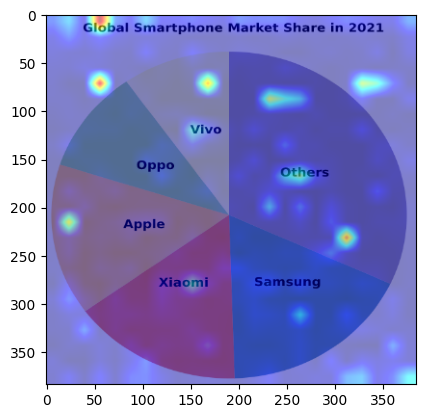

In [11]:
cam_grid = cam_tensor.reshape(24, 24)


cam = generate_gradcam(cam_grid, image)

plt.imshow(cam)
plt.show(cam)

In [12]:
attention_scores = torch.stack(outputs.attentions)
attention_scores.shape

torch.Size([30, 1, 32, 627, 627])

In [13]:
# locate image and input texts
cross_attention = attention_scores[:, :, :, 620: -4, 42: 618] # layer, batch, head, text_token, image_token
cross_attention.shape

torch.Size([30, 1, 32, 3, 576])

In [14]:
cam_tensor_arr = cam_tensor.detach().to(float).to("cpu").numpy()
cam_tensor_arr.shape

(24, 24)

In [15]:
# predicted_ids = np.argmax(output_arr, axis=-1) # [1, num_tokens]
# predicted_ids = predicted_ids.squeeze(0) # [num_tokens]
# answer = tokenizer.decode(predicted_ids[target_token_idx].tolist())
# # answer = tokenizer.decode(predicted_ids.tolist())
# answer

In [16]:
answer = tokenizer.decode(predicted_ids.tolist())
answer

NameError: name 'predicted_ids' is not defined

In [ ]:
input_ids_decoded_str = ""
for token_decoded in input_ids_decoded:
    input_ids_decoded_str += token_decoded
input_ids_decoded_str

'<｜begin▁of▁sentence｜>You are a helpful language and vision assistant. You are able to understand the visual content that the user provides, and assist the user with a variety of tasks using natural language.\n\n<|User|>: <begin_of_image><image_placeholder><image_placeholder><image_placeholder><image_placeholder><image_placeholder><image_placeholder><image_placeholder><image_placeholder><image_placeholder><image_placeholder><image_placeholder><image_placeholder><image_placeholder><image_placeholder><image_placeholder><image_placeholder><image_placeholder><image_placeholder><image_placeholder><image_placeholder><image_placeholder><image_placeholder><image_placeholder><image_placeholder><image_placeholder><image_placeholder><image_placeholder><image_placeholder><image_placeholder><image_placeholder><image_placeholder><image_placeholder><image_placeholder><image_placeholder><image_placeholder><image_placeholder><image_placeholder><image_placeholder><image_placeholder><image_placeholder><i

In [ ]:
input_ids_decoded[start:-4]
# input_ids_decoded[41: 619]
# input_ids_decoded

['What',
 ' is',
 ' the',
 ' coffee',
 ' price',
 ' in',
 ' April',
 ' ',
 '2',
 '0',
 '1',
 '9',
 '?']

## locate token ##

In [ ]:
target_token = '<end_of_image>'
target_token = '<begin_of_image>'
for i, token in enumerate(input_ids_decoded):
    if token == target_token:
        print(i)
        break

41


In [ ]:
input_ids_decoded[target_token_idx]

'What'

In [ ]:
# [1, 576 + 1, 1024] -> adapter -> [1, 576  2048] -> "<system> You are an expert of .... <IMG><IMG>。。。"